# Machine Learning - Classification model
## by Vesna Pop-Dimitrijoska
---

#### We have classification problem where we have to predict whether a credit would be approved or not for a client.
#
|Field Name|	Order|	Type (Format)|Description|
| -------| -------|-----------|---------|
|checking_status|	1|	string (default)|Status of existing checking account, in Deutsche Mark.|	
|duration	|2|	number (default)	|Duration in months|
|credit_history	|3|	string (default)	|Credit history (credits taken, paid back duly, delays, critical accounts)|
|purpose	|4|	string (default)	|Purpose of the credit (car, television,…)|
|credit_amount	|5|	number (default)	|Credit amount|
|savings_status	|6|	string (default)	|Status of savings account/bonds, in Deutsche Mark.|
|employment	|7|	string (default)	|Present employment, in number of years.|
|installment_commitment	|8|	number (default)|Installment rate in percentage of disposable income|	
|personal_status	|9|	string (default)|Personal status (married, single,…) and sex|
|other_parties	|10|	string (default)|Other debtors / guarantors|	
|residence_since	|11|	number (default)|Present residence since X years|	
|property_magnitude	|12|	string (default)|Property (e.g. real estate)|	
|age	|13|	number (default)	|Age in years|
|other_payment_plans	|14|	string (default)|Other installment plans (banks, stores)|
|housing	|15|	string (default)	|Housing (rent, own,…)|
|existing_credits	|16|	number (default)|Number of existing credits at this bank|	
|job	|17|	string (default)	|Job|
|num_dependents	|18|	number (default)|Number of people being liable to provide maintenance for|	
|own_telephone	|19|	string (default)|Telephone (yes,no)|	
|foreign_worker	|20|	string (default)|Foreign worker (yes,no)|	
accepted	|21|	string (default)	|Class|

---
# Loading the libraries

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm       
import copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from collections import Counter
                     
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, make_scorer, confusion_matrix, classification_report

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

---
# Read the Dataset

In [2]:
org_df = pd.read_csv('dataset.csv', index_col=0).reset_index(drop=True) # we keep this in case we need the original dataset
df = org_df.copy()

display(df.head())

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,accepted
0,0_checking,6,Critical_acct_other_credits_existing,radio/television,3380.000000,Unknown_or_no_savings_acct,>7yrs,4,male_single,None,...,real_estate,NaN,none,own,2,skilled_employee/official,1,yes,yes,0
1,from_0_to_200,48,Existing_credits_paid_till_now,radio/television,6940.208336,<100DM,1_to_4yrs,2,female_divorced/separated/married,None,...,real_estate,22.0,none,own,1,skilled_employee/official,1,none,yes,1
2,None,12,Critical_acct_other_credits_existing,education,1902.370483,<100DM,4_to_7yrs,2,male_single,None,...,real_estate,49.0,none,own,1,unskilled_resident,2,none,yes,0
3,0_checking,42,Existing_credits_paid_till_now,furniture/equipment,1097.000000,<100DM,4_to_7yrs,2,male_single,guarantor,...,building_society_savings_agreement/life_insurance,45.0,none,for_free,1,skilled_employee/official,2,none,yes,0
4,0_checking,24,Delay_in_past,new_car,9021.266894,<100DM,1_to_4yrs,3,male_single,None,...,unknown/no_property,53.0,none,for_free,2,skilled_employee/official,2,none,yes,1


---
# Preliminary analysis of a dataset

In [3]:
print('Basic info of the dataset:\n-------------------------------------------------------------')
print(df.info(), '\n\n')

print('Sum of NaN values in each column:\n-------------------------------------------------------------')
print(df.isna().sum(), '\n\n')

print('Duplicates in the dataset:\n-------------------------------------------------------------')
print(df.loc[df.duplicated()])

print('\nUnique data in the dataset:\n-------------------------------------------------------------')
print(df.nunique().sort_values())

Basic info of the dataset:
-------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1003 non-null   object 
 1   duration                1003 non-null   object 
 2   credit_history          1003 non-null   object 
 3   purpose                 1003 non-null   object 
 4   credit_amount           1003 non-null   float64
 5   savings_status          1003 non-null   object 
 6   employment              1003 non-null   object 
 7   installment_commitment  1003 non-null   int64  
 8   personal_status         1003 non-null   object 
 9   other_parties           1003 non-null   object 
 10  residence_since         1003 non-null   int64  
 11  property_magnitude      1003 non-null   object 
 12  age                     953 non-null    float64
 13  othe

In [4]:
# Summary Statistics of the dataset
df.describe()

,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,accepted
count,1003.000000,1003.000000,1003.000000,953.000000,1003.00000,1003.000000,1003.000000
mean,4504.065569,2.973081,2.845464,35.579224,1.40678,1.154536,0.299103
std,3656.278869,1.117933,1.103002,11.347096,0.57738,0.361642,0.458093
min,505.000000,1.000000,1.000000,19.000000,1.00000,1.000000,0.000000
25%,1918.697453,2.000000,2.000000,27.000000,1.00000,1.000000,0.000000
50%,3667.064141,3.000000,3.000000,33.000000,1.00000,1.000000,0.000000
75%,5896.315833,4.000000,4.000000,42.000000,2.00000,1.000000,1.000000
max,27389.000000,4.000000,4.000000,75.000000,4.00000,2.000000,1.000000


In [5]:
# Analysis of unique categories in categorical data

categorical_columns = df.select_dtypes('object').columns
numerical_columns = df.select_dtypes('number').columns

for column in categorical_columns:
    print(f'{column}:\n', df[column].unique(), '\n')

checking_status:
 ['0_checking' 'from_0_to_200' 'None' 'zero_checking' 'more_than_200'
 'from_zero_to_200' 'more_then_200'] 

duration:
 ['6' '48' '12' '42' '24' '36' '30' 'None' '15' '9' '10' '7' '60' '18`'
 '45' '11' '27' '8' '54' '20' '14' '33' '21' '16' '4' '47' '13' '22' '28'
 '5' '39' '26' '72' '40'] 

credit_history:
 ['Critical_acct_other_credits_existing' 'Existing_credits_paid_till_now'
 'Delay_in_past' 'None' 'No_credits_taken_or_all_paid'
 'All_credits_paid_duly'] 

purpose:
 ['radio/television' 'education' 'furniture/equipment' 'new_car' 'used_car'
 'newcar' 'business' 'usedcar' 'domestic_appliances' 'repairs' 'other'
 'retraining'] 

savings_status:
 ['Unknown_or_no_savings_acct' '<100DM' '500_to_1000DM' '>1000DM'
 '100_to_500DM'] 

employment:
 ['>7yrs' '1_to_4yrs' '4_to_7yrs' 'unemployed' '<1yr'] 

personal_status:
 ['male_single' 'female_divorced/separated/married'
 'male_divorced/separated' 'male_married/widowed'
 'feemale_divorced/separated/married'] 

other_parties:

---
# CONCLUSION from preliminary analysis of a dataset:
---
### Shape of a Dataset:     
Shape of the dataset is 1003 rows x 21 columns.

### NaN values:  
The dataset contains 50 NaN values in column "Age", that should be imputed.

The dataset contains "None" values in 6 columns which are considered as NaN values because their exact meaning is uncertain, and so they should be handled accordingly.
Some of the features contain a high percentage of 'None' values, therefore, I've decided to remove these columns from the dataset.
The ones with lower percentage of 'None' values, will be imputed. 

Imputing of all data is done with KNNImputer in the code below, after encoding the data.  

### Data types:  
Two columns doesnt have correct data types, and they should be converted: "duration" and "accepted".
Since column "accepted" is a target class of our classification problem with binary output it's not necessary to convert the target variable into a string, but I've decided to do it just for clarification and as a practice that needs to be done in further more complicated models. 

### Duplicates:  
There are no duplicate rows in the dataset.

### Typos:       
There are 8 instance typos (categories typos in categorical data), that need to be corrected.

### Descriptive statistics:
The summary statistics for the numerical columns in the dataset shows quick overview of the distribution and data variability that occurs in all columns. The only thing that could be done according to this analysis is scaling of some features to ensure that they are on a similar scale, because some ML algorithms are sensitive to the scale of the features.

---
# Handling Typos and Spelling Errors

In [6]:
'''
Typos correction: 
There are 8 instance typos, that need to be corrected in the columns: purpose, duration, checking_status and personal_status

---------------------------------------------------------------------------------------
column 'purpose':  
                    'newcar'           -> 'new_car' 
                    'usedcar'          -> 'used_car' 
---------------------------------------------------------------------------------------        
column 'duration': 
                    '18`'              -> '18'
            
---------------------------------------------------------------------------------------       
column 'checking_status': 
                    'zero_checking'    -> '0_checking'       
                    'from_zero_to_200' -> 'from_0_to_200'
                    'more_than_200'    -> 'more_then_200'
---------------------------------------------------------------------------------------        
column 'personal_status': 
                    'female_divorced/separated/married' -> 'feemale_divorced/separated/married'
            
---------------------------------------------------------------------------------------
'''

df['purpose'] = df['purpose'].replace('newcar', 'new_car')
df['purpose'] = df['purpose'].replace('usedcar', 'used_car')

df['duration'] = df['duration'].replace('18`', '18')

df['checking_status'] = df['checking_status'].replace('zero_checking', '0_checking')
df['checking_status'] = df['checking_status'].replace('from_zero_to_200', 'from_0_to_200')
df['checking_status'] = df['checking_status'].replace('more_then_200', 'more_than_200')

df['personal_status'] = df['personal_status'].replace('usedcar', 'used_car')
df['personal_status'] = df['personal_status'].replace('feemale_divorced/separated/married', 'female_divorced/separated/married')


print('purpose:', df['purpose'].unique(), '\n')
print('duration:', df['duration'].unique(), '\n')
print('checking_status:', df['checking_status'].unique(), '\n')
print('personal_status:', df['personal_status'].unique(), '\n')

purpose: ['radio/television' 'education' 'furniture/equipment' 'new_car' 'used_car'
 'business' 'domestic_appliances' 'repairs' 'other' 'retraining'] 

duration: ['6' '48' '12' '42' '24' '36' '30' 'None' '15' '9' '10' '7' '60' '18' '45'
 '11' '27' '8' '54' '20' '14' '33' '21' '16' '4' '47' '13' '22' '28' '5'
 '39' '26' '72' '40'] 

checking_status: ['0_checking' 'from_0_to_200' 'None' 'more_than_200'] 

personal_status: ['male_single' 'female_divorced/separated/married'
 'male_divorced/separated' 'male_married/widowed'] 



---
# Handling missing values (Detailed analysis and Deletion)

In [7]:
'''
Irrelevant features: 
-------------------------------------------------------------------------------------------------------------------
    'own_telephone'

This feature in my opinion is non-informative and irrelevant so it should be left out from the predictive ML model. 
It has low feature importance and had low correlation with the target variable (This was analysed before it was deleted).
'''

cols_to_drop_irr = ['own_telephone']
df = df.drop(columns=cols_to_drop_irr)

In [8]:
'''
Features with 'None' values:
-------------------------------------------------------------------------------------------------------------------
    'checking_status'
    'other_parties'
    'other_payment_plans'
    'duration'
    'credit_history'

Some of the features contain a high percentage of 'None' values whose exact meaning is uncertain. 
Therefore, I've decided to remove them from the dataset.
The ones with lower percentage of 'None' values, will be imputed. 
Imputing is done with KNNImputer in the code below, after encoding the data.  
'''

n1 = df[df['checking_status']     == 'None'].groupby(['checking_status'])[['checking_status']].count()/len(df)*100
n2 = df[df['other_parties']       == 'None'].groupby(['other_parties'])[['other_parties']].count()/len(df)*100 
n3 = df[df['other_payment_plans'] == 'none'].groupby(['other_payment_plans'])[['other_payment_plans']].count()/len(df)*100
n4 = df[df['duration']            == 'None'].groupby(['duration'])[['duration']].count()/len(df)*100
n5 = df[df['credit_history']      == 'None'].groupby(['credit_history'])[['credit_history']].count()/len(df)*100

print("Column 'checking_status' has:    ", round(n1.values[0][0], 2), "% 'None' values")
print("Column 'other_parties' has:      ", round(n2.values[0][0], 2), "% 'None' values")
print("Column 'other_payment_plans' has:", round(n3.values[0][0], 2), "% 'None' values")
print("Column 'duration' has:            ",round(n4.values[0][0], 2), "% 'None' values")
print("Column 'credit_history' has:      ",round(n5.values[0][0], 2), "% 'None' values")

cols_to_drop_none = ['checking_status', 'other_parties', 'other_payment_plans']
df = df.drop(columns=cols_to_drop_none)

df['duration'] = df['duration'].replace('None', np.nan)
df['credit_history'] = df['credit_history'].replace('None', np.nan)

Column 'checking_status' has:     39.28 % 'None' values
Column 'other_parties' has:       90.73 % 'None' values
Column 'other_payment_plans' has: 81.46 % 'None' values
Column 'duration' has:             5.28 % 'None' values
Column 'credit_history' has:       4.99 % 'None' values


---
# Conversion to appropriate data types

In [9]:
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
df['accepted'] = df['accepted'].astype(str)

---
# Exploratory Data Analysis

In [10]:
categorical_columns = df.select_dtypes('object').columns
numerical_columns = df.select_dtypes('number').columns

cat_cols = list(set(categorical_columns) - set(cols_to_drop_irr) - set(cols_to_drop_none)) 
num_cols = list(set(numerical_columns))

Distribution of the target class:
-----------------------------------------------------------------------------------------------------------
0    703
1    300
Name: accepted, dtype: int64 




<Axes: xlabel='accepted', ylabel='count'>

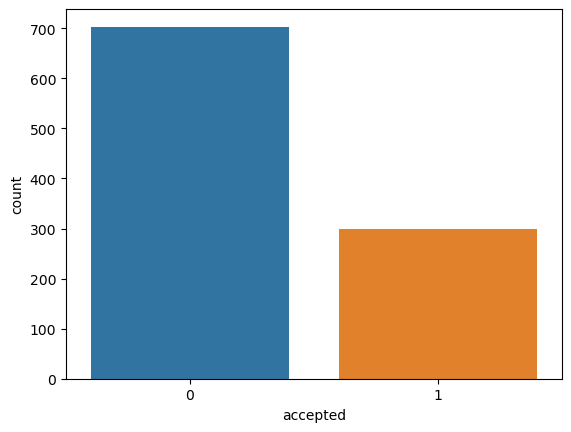

In [11]:
print('Distribution of the target class:')
print('-----------------------------------------------------------------------------------------------------------')
print(df['accepted'].value_counts(), '\n\n')

sns.countplot(x=df['accepted'])

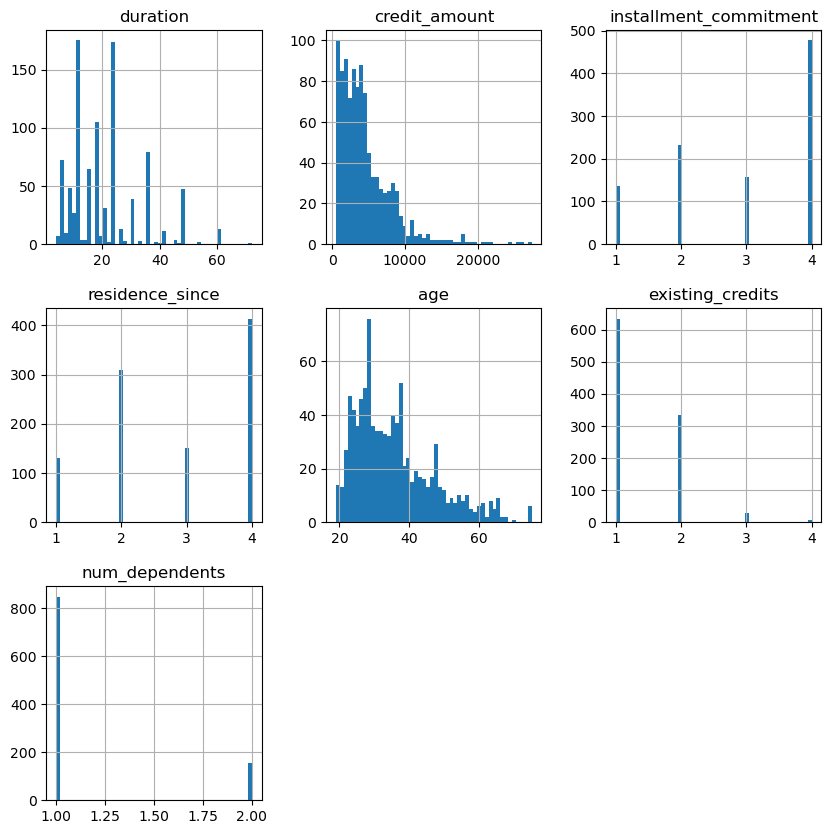

In [12]:
df.hist(figsize=(10,10),bins=50)
plt.show()

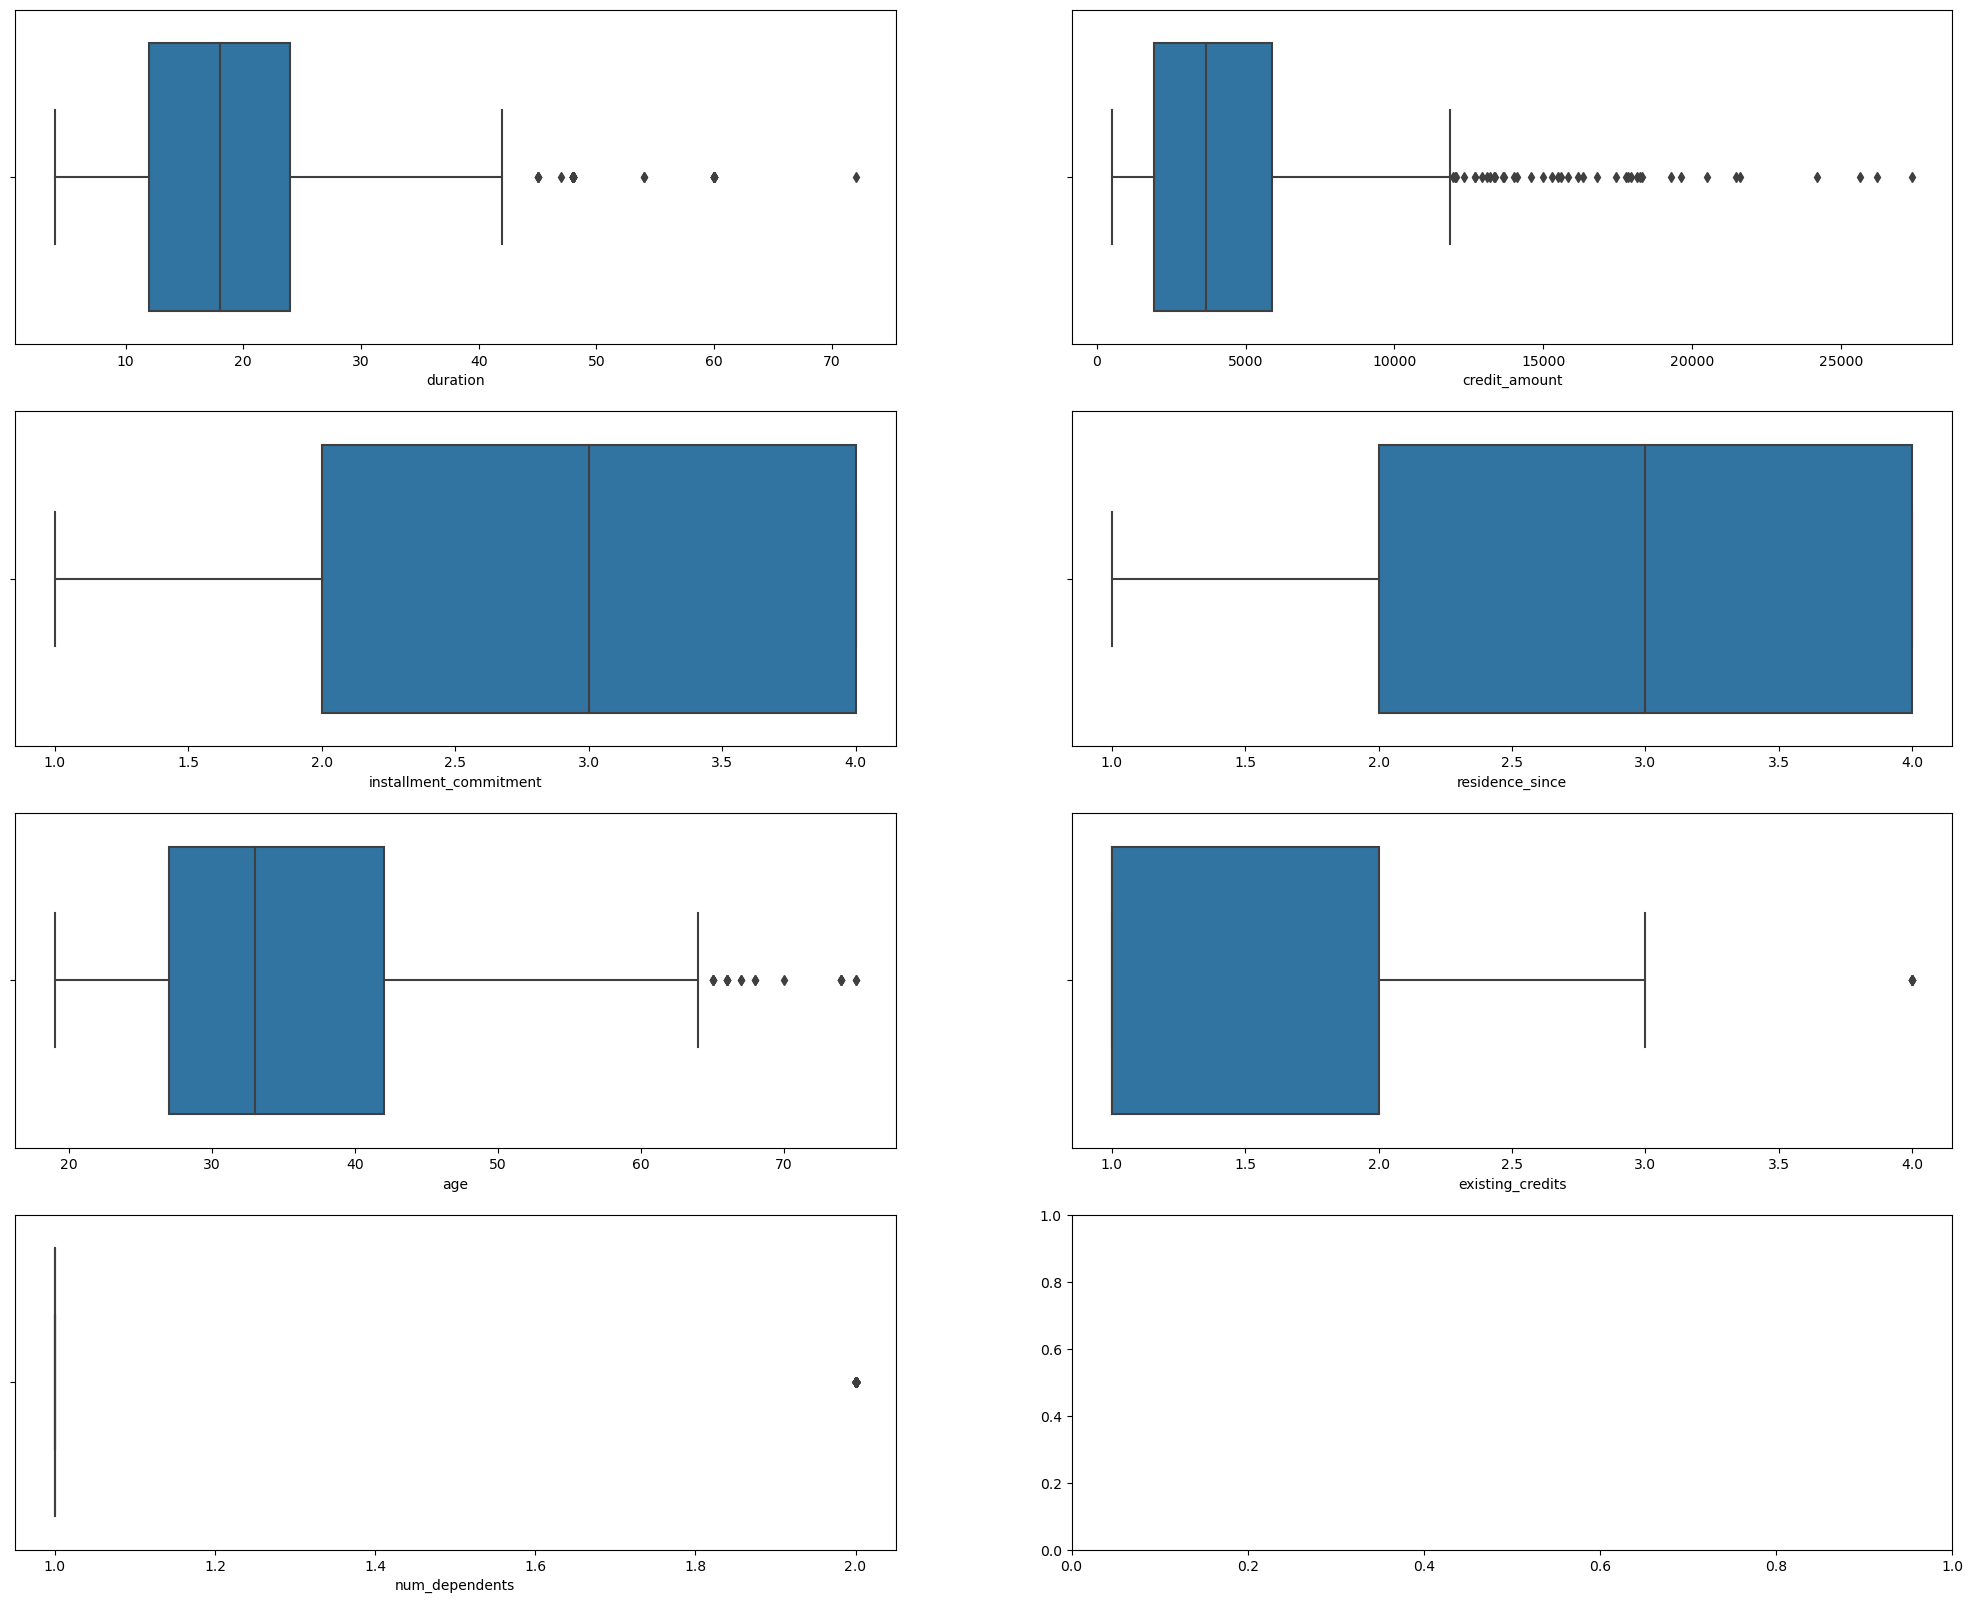

In [13]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(25,20))
axs = axs.ravel()

numerical_columns = df.select_dtypes('number').columns
for i, c in enumerate(numerical_columns):
    sns.boxplot(df, x=df[c], orient='h', ax=axs[i])

---
# Handling Outliers 
## Data Transformations on the features with skewed distribution

Boxplots after features transformation.


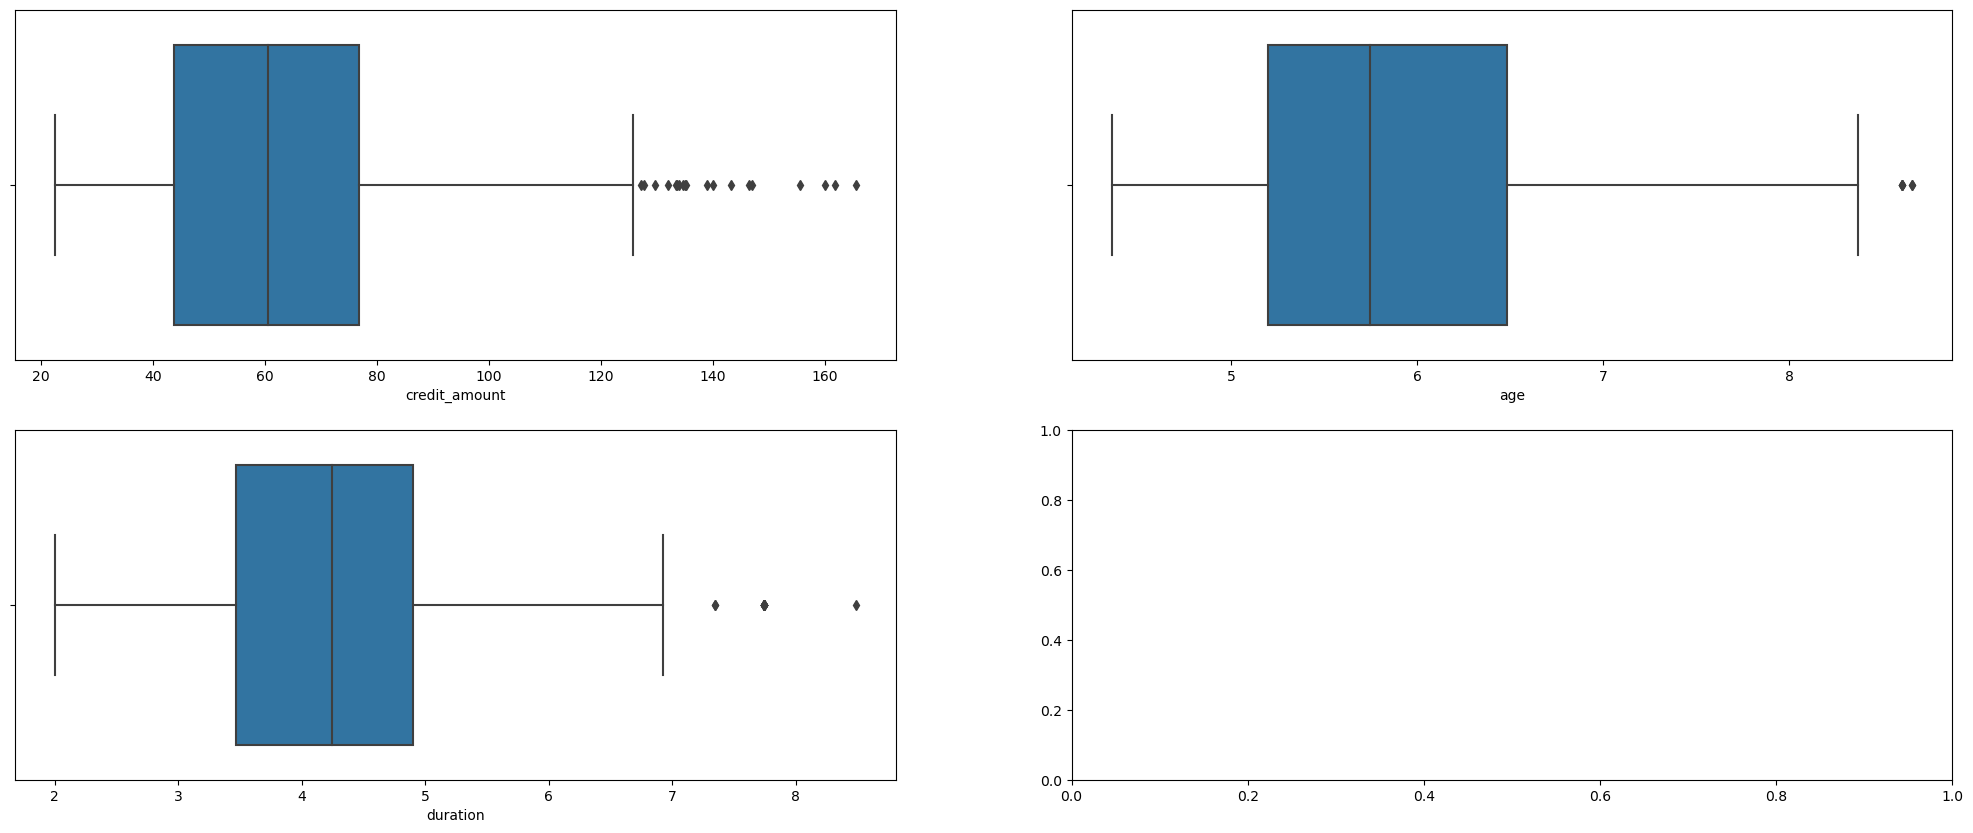

In [14]:
df['credit_amount'] = df['credit_amount'].apply(np.sqrt)
df['age'] = df['age'].apply(np.sqrt)
df['duration'] = df['duration'].apply(np.sqrt)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(25,10))
axs = axs.ravel()

for i, c in enumerate(df[['credit_amount', 'age', 'duration']]):
    sns.boxplot(df, x=df[c], orient='h', ax=axs[i])
    
print('Boxplots after features transformation.')

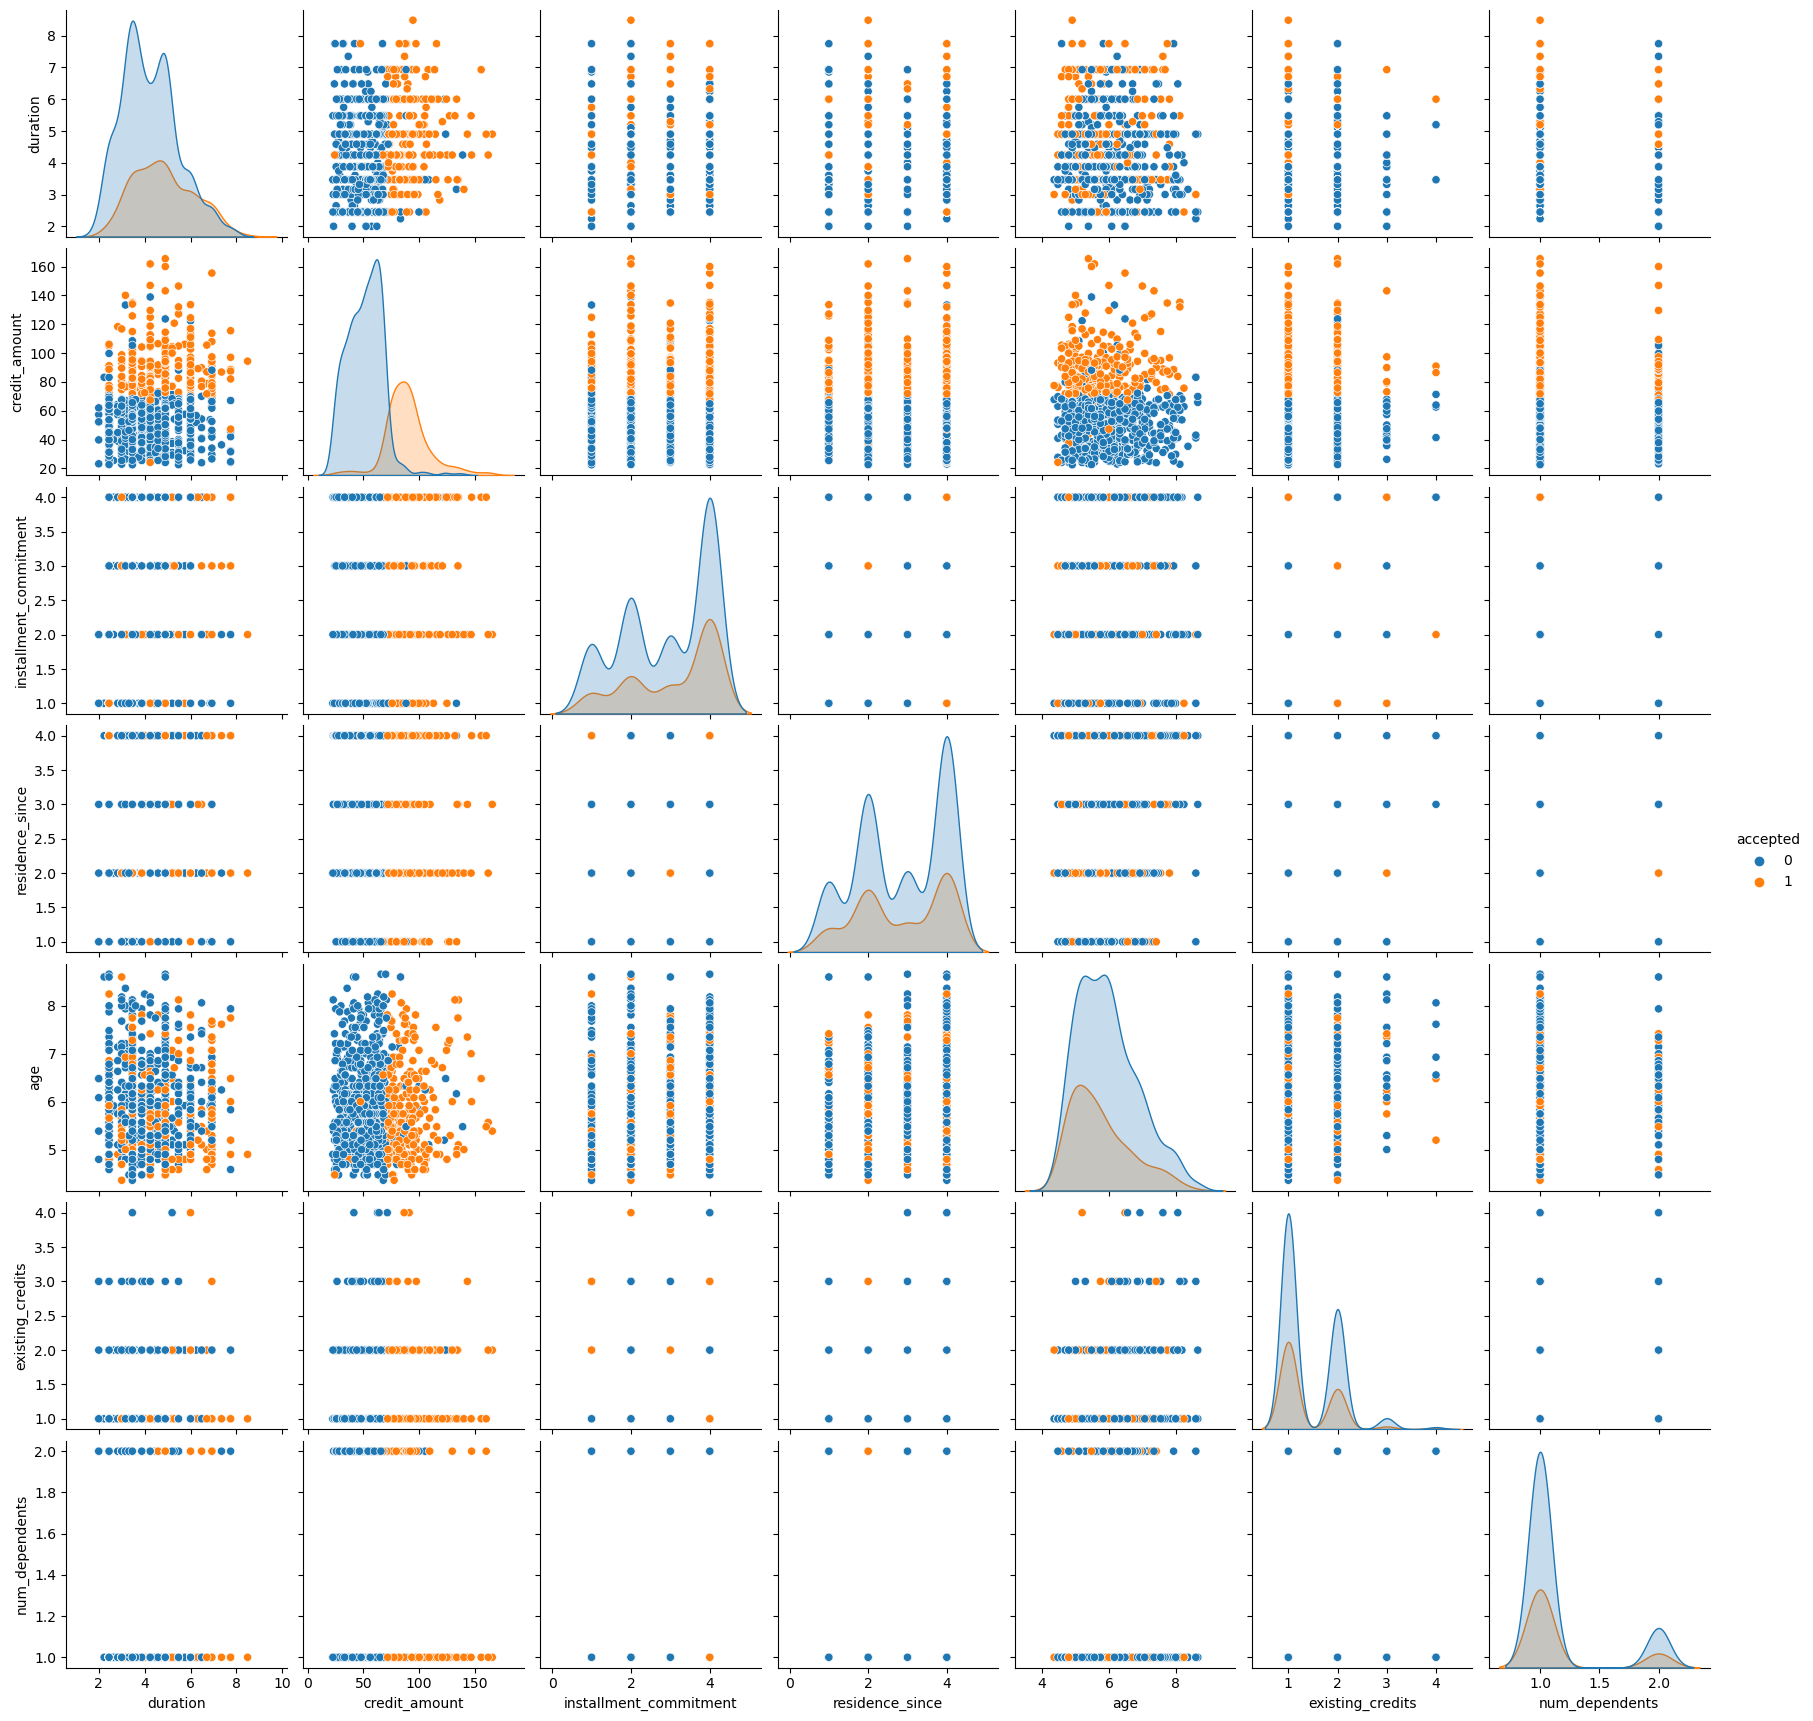

In [15]:
sns.pairplot(df, hue='accepted')

---
# Encoding Categorical features

In [16]:
for c in cat_cols:
    df[c] = LabelEncoder().fit_transform(df[c].values)

---
# Exploratory Data Analysis on entire dataset (including encoded features)

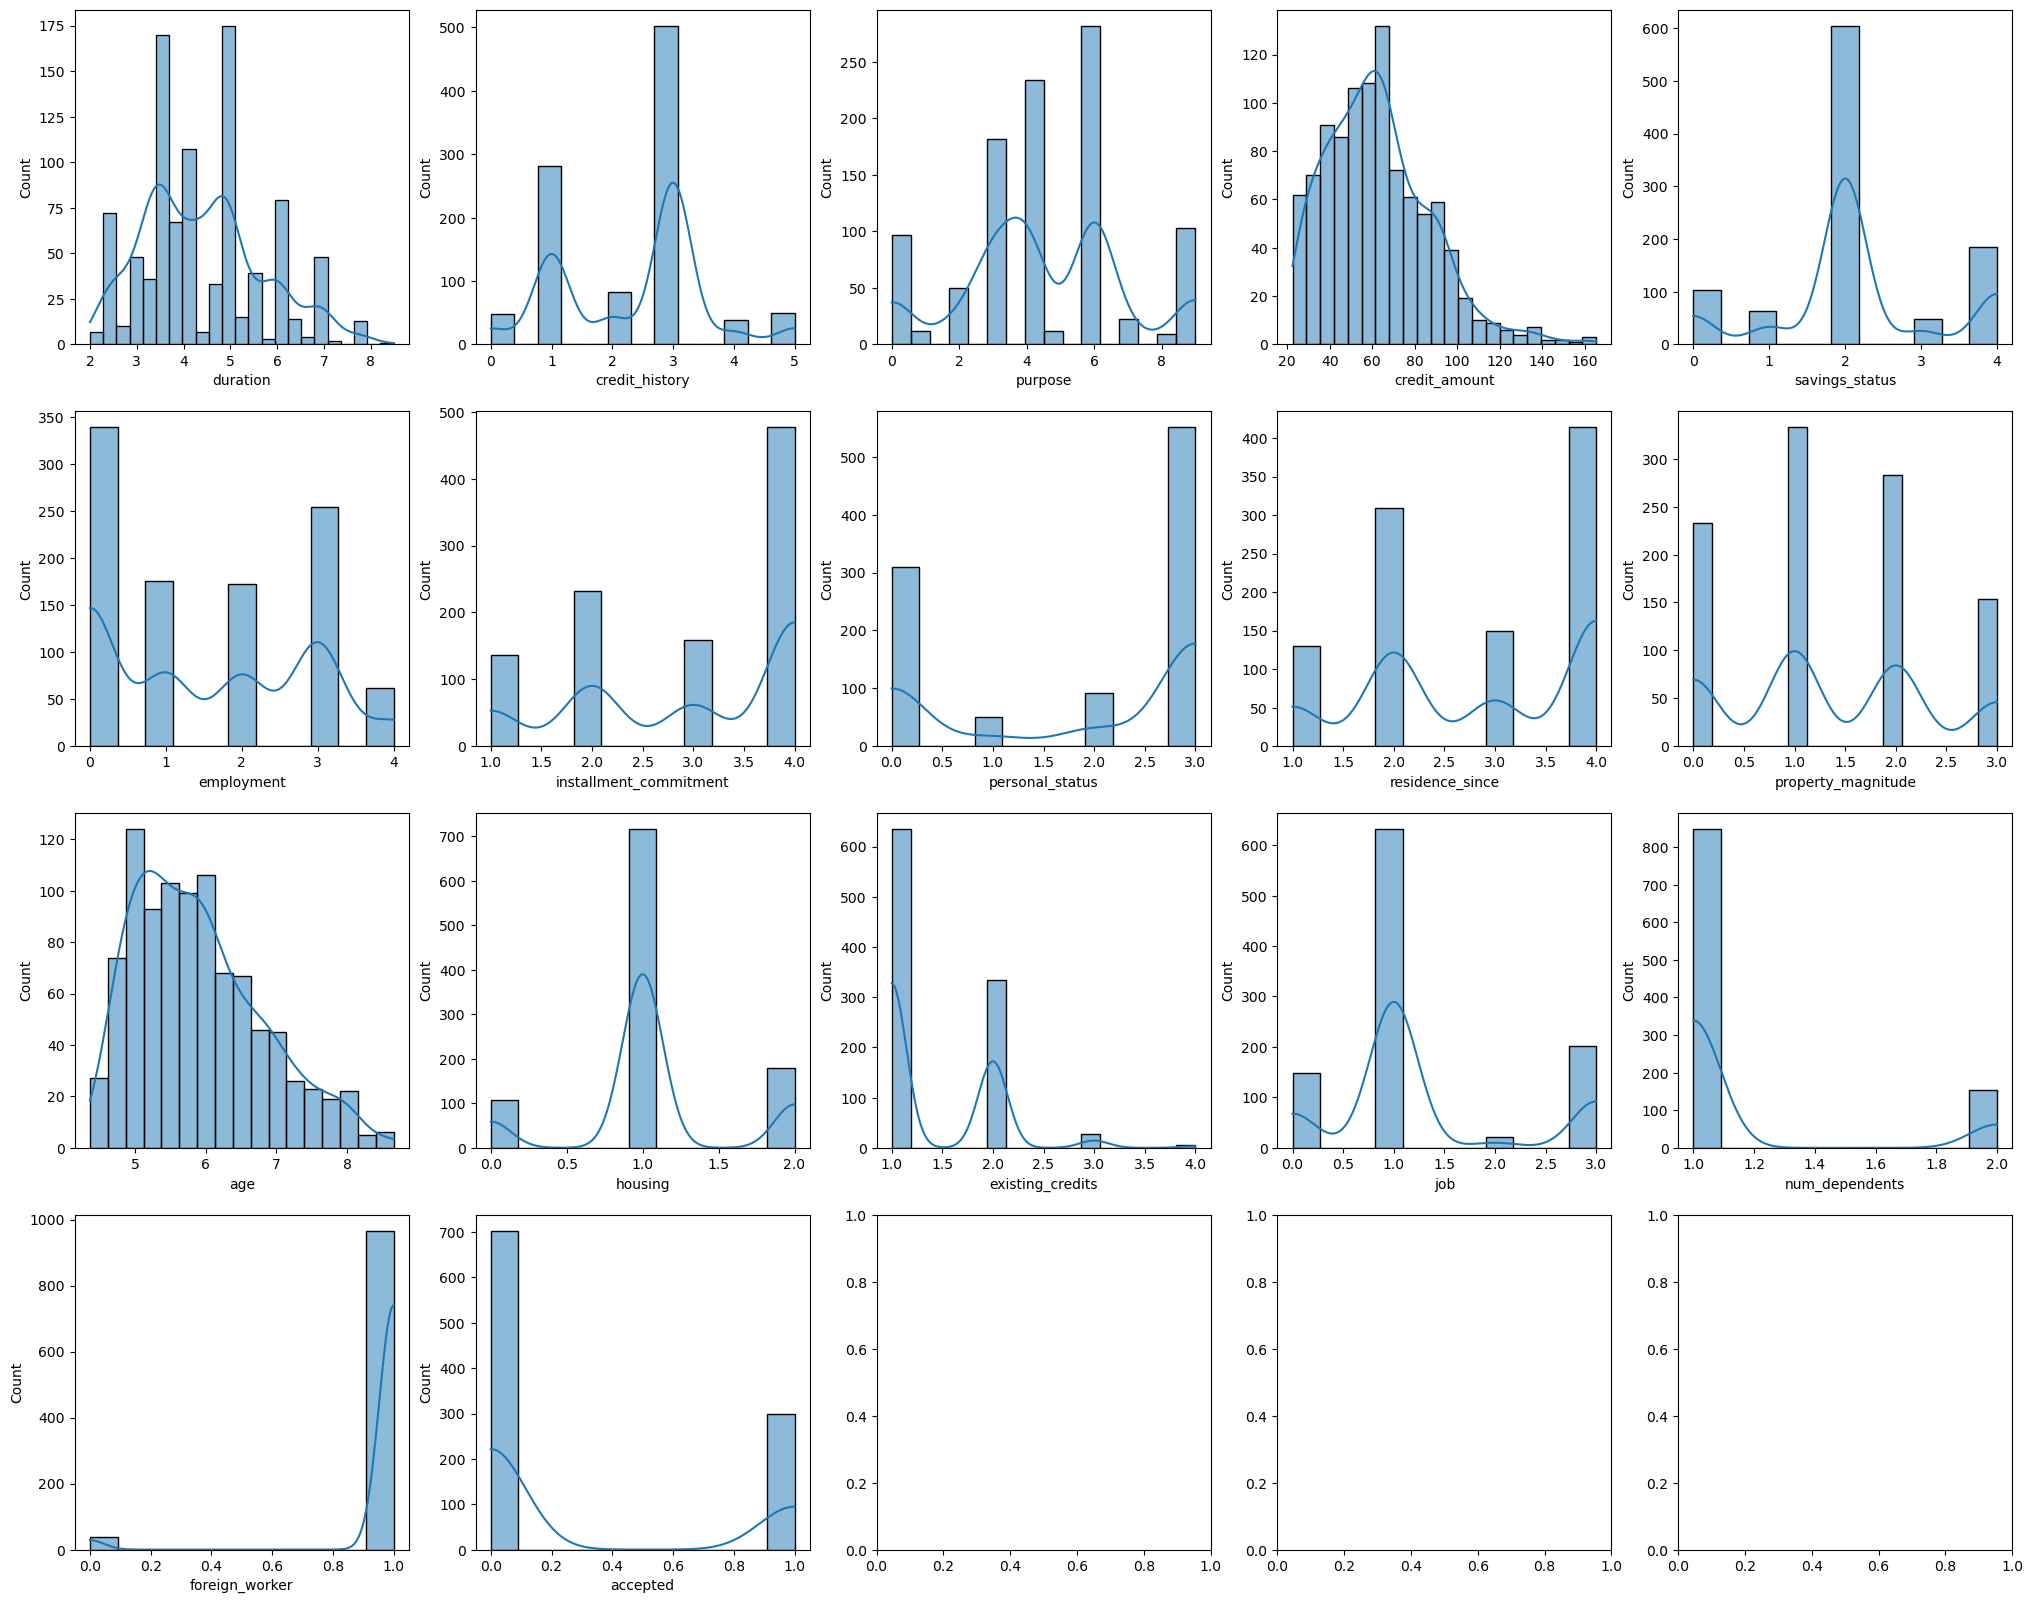

In [17]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(25,20 ))
axs = axs.ravel()

for i, c in enumerate(df):
    sns.histplot(df, x=df[c], ax=axs[i], kde=True)

<Axes: >

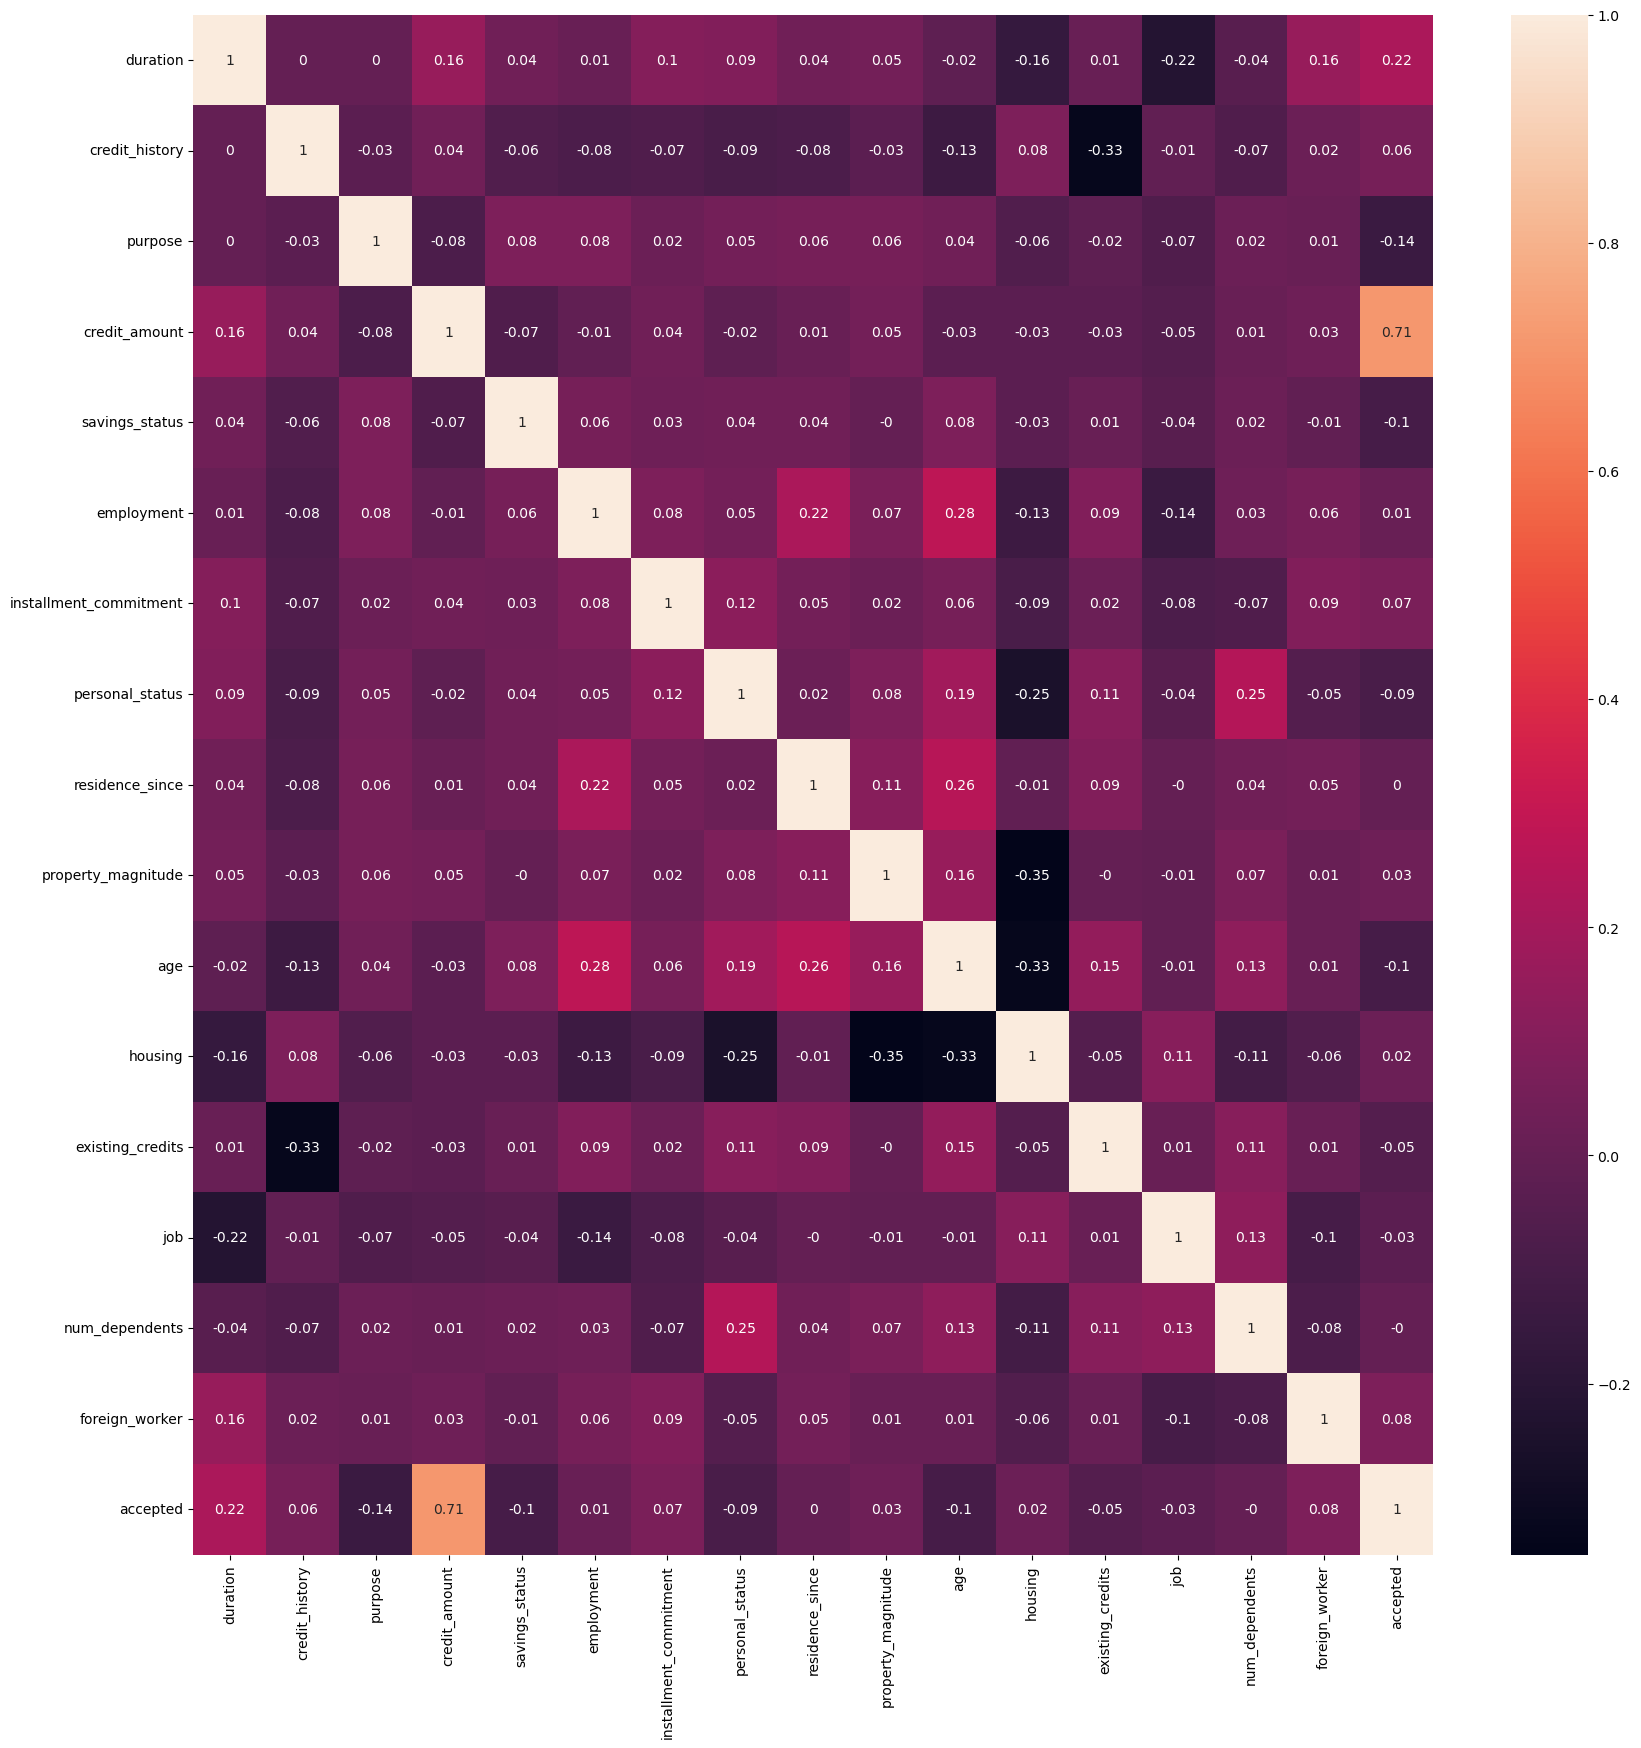

In [18]:
df_corr = df.corr(numeric_only=True, method='pearson').round(decimals=2)
plt.figure(figsize=(20,20))
sns.heatmap(df_corr, annot=True)

---
# CONCLUSION from EDA:

---
### Target class: 
The target class is not uniformly distributed, so therefore the best way is to use Stratified K-Folds cross-validaton in order to compute different test scores on different folds of the data.

### Key findings from Histograms:  
There is a exponental distribution detected in "credit_amount" feature and there is a negative skewed distribution detected on features: "age" and "duration".

### Key findings from Boxplots:
Similar to histograms тhere is a skewed distribution with many outliers detected on features: "credit_amount", "age" and "duration" column. Transformation resulted in reducing the skewness in these features. 

### Transformation on the features with skewed distribution:
Transformation are not part of Exploratory Data Analysis, but are done here in order to better analyse post-transformation results. Transformation was made by applying np.sqrt() function on the skewed features. This function was less aggressive in handling outliers compared to logarithmic transformation, which gave me low performance on ML model.

### Key findings from Histplots:
Since this plot was made after transformation, there is reduced skewness in the features showed on these plots.

There is unbalanced dataset in two of the features: 'foreign_worker' and 'num_dependents', but this features were left in the model because it was determined that they don't affect the final score.

### Key findings from Heatmap:
##### Correlation Target - Features: 
Heatmap shows strong positive correlation above 0.7 between target class: 'accepted' and feature: 'credit_amount'. So maybe it is a good idea to give more weight to this feature in order to achive better model performance.

Target class has low correlation with other features, but this is not enough reason to remove these features from the model.  

##### Correlation Feature - Feature:
Also there is no big correlation between the features themselves in the dataset, which suggests that no feature should be removed from the dataset.

### Key findings from Pairplot:
Pairwise relationships between variables in a dataset shows intresting distribution and correlations, especialy between 'credit_amount' and all other features in the dataset. This is sugesting that maybe this feature is KEY PREDICTOR in the predictive model. 

From the pairplot it can be seen that only lower credit amounts were accepted for credit approval, and almost all of the bigger credit amounts were not accepted. 

---

#
#

---
# Dividing the dataset: 
### X-Class/Target column and y-Features/Attributes 

In [19]:
X = df.drop(columns=['accepted'])                                 
y = df['accepted']

---
# Handling missing values (Imputing the NaN values with the KNN algorithm

In [20]:
# Imputing the NaN values with the KNN algorithm, which we ONLY apply to features
X = pd.DataFrame(KNNImputer(n_neighbors=10).fit_transform(X), columns=X.columns).astype(int)

# checking if all NaN values are imputed
X.isna().sum()

duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
residence_since           0
property_magnitude        0
age                       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
foreign_worker            0
dtype: int64

In [21]:
cat_cols = list(set(categorical_columns) - set(cols_to_drop_irr) - set(cols_to_drop_none) - {'accepted'}) 

---
# Train and evaluate the model with Cross validation 

In [27]:
for algo in (
    GaussianNB(),
    DecisionTreeClassifier(max_depth=5, random_state=SEED), 
    KNeighborsClassifier(n_neighbors=3),
    SVC(kernel='rbf', C=100, random_state=SEED),
    RandomForestClassifier(max_depth=10, n_estimators=100, random_state=SEED),
    AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10, random_state=SEED), n_estimators=100, learning_rate=1.0, random_state=SEED) 
):

    col_trans = ColumnTransformer([
        ('mms', MinMaxScaler(), num_cols),
        ('pass', 'passthrough', cat_cols)
    ])
    

    pipeline = Pipeline([
        ('col_transformer', col_trans),
        ('rfc', algo)
    ])
    
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    
    rez_f1 = cross_val_score(pipeline, X, y, cv=kf, scoring=make_scorer(f1_score))
    rez_a  = cross_val_score(pipeline, X, y, cv=kf, scoring=make_scorer(accuracy_score))
    rez_p  = cross_val_score(pipeline, X, y, cv=kf, scoring=make_scorer(precision_score))
    rez_r  = cross_val_score(pipeline, X, y, cv=kf, scoring=make_scorer(recall_score))
    
    print(f'5 KFold score for {algo}:')
    print('--------------------------------------------------------------------------------------')
    print('F1 score (macro):   ', round((np.mean(rez_f1))*100,2), '%')
    print('Accuracy score:     ', round((np.mean(rez_a))*100, 2), '%')
    print('Precision score:    ', round((np.mean(rez_p))*100, 2), '%')
    print('Recall score:       ', round((np.mean(rez_r))*100, 2), '%\n\n')


5 KFold score for GaussianNB():
--------------------------------------------------------------------------------------
F1 score (macro):    86.09 %
Accuracy score:      91.42 %
Precision score:     84.12 %
Recall score:        88.33 %


5 KFold score for DecisionTreeClassifier(max_depth=5, random_state=42):
--------------------------------------------------------------------------------------
F1 score (macro):    91.36 %
Accuracy score:      94.81 %
Precision score:     91.42 %
Recall score:        91.67 %


5 KFold score for KNeighborsClassifier(n_neighbors=3):
--------------------------------------------------------------------------------------
F1 score (macro):    35.22 %
Accuracy score:      66.8 %
Precision score:     42.41 %
Recall score:        30.33 %


5 KFold score for SVC(C=100, random_state=42):
--------------------------------------------------------------------------------------
F1 score (macro):    75.98 %
Accuracy score:      85.74 %
Precision score:     77.25 %
Recall

---
# RESULTS:
---

After evaluating multiple models on our dataset, I have determined that the best model is RandomForestClassifier(max_depth=10, random_state=42), which consistently outperforms the others in terms of F1 score (macro), Accuracy score, Precision score and Recall score.

#####

## 5 KFold score for RandomForestClassifier:
---
    F1 score (macro):    92.91 %
    Accuracy score:      95.71 %
    Precision score:     91.93 %
    Recall score:        94.00 %

---

#####

# RECOMMENDATIONS FOR FUTURE IMPROVEMENT:
---

In the future, we can focus on the following areas to further enhance our model's performance:

### * Assign more weight to KEY PREDICTOR
By assigning more weight to possible KEY PREDICTOR 'credit_amount' may lead to improved model performance.

### * Feature Engineering: 
Some additional feature transformation could potentially provide more valuable information for the model.

### * Hyperparameter Tuning: 
Conducting a thorough search for optimal hyperparameters can lead to improved model performance.

### * Ensemble Methods: 
Implementing additional ensemble techniques may help capture complex relationships in the data.

By addressing all of these areas, we aim to further enhance the accuracy and reliability of our predictive model.

#

## Issues with the model
Аlthough a constant random_state was used everywhere in the model, it was observed that there was a slight deviation in the results in all of DecisionTreeClassifiers (baseline and ensambles) with each new execution of the code (where Kernel was restarted) of max ±1% at DecisionTree and RandomForest, and ±3% at AdaBoost model. I was not able to find out what this result was due to.



---
# Train and evaluate the model ONLY with KeyPredictor column


In [23]:
key_predictor = list({'credit_amount'})

for algo in (
    GaussianNB(),
    DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=SEED), 
    KNeighborsClassifier(n_neighbors=3),
    SVC(kernel='rbf', C=100, random_state=SEED),
    RandomForestClassifier(max_depth=4, random_state=SEED),
    AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10), n_estimators=100, learning_rate=1.0, random_state=SEED) 
):

    col_trans = ColumnTransformer([
        ('mms', MinMaxScaler(), key_predictor)
    ])
    

    pipeline = Pipeline([
        ('col_transformer', col_trans),
        ('rfc', algo)
    ])
    
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    
    rez_f1 = cross_val_score(pipeline, X, y, cv=kf, scoring=make_scorer(f1_score))
    rez_a  = cross_val_score(pipeline, X, y, cv=kf, scoring=make_scorer(accuracy_score))
    rez_p  = cross_val_score(pipeline, X, y, cv=kf, scoring=make_scorer(precision_score))
    rez_r  = cross_val_score(pipeline, X, y, cv=kf, scoring=make_scorer(recall_score))
    
    print(f'5 KFold score for {algo}:')
    print('--------------------------------------------------------------------------------------')
    print('F1 score (macro):   ', round((np.mean(rez_f1))*100,2), '%')
    print('Accuracy score:     ', round((np.mean(rez_a))*100, 2), '%')
    print('Precision score:    ', round((np.mean(rez_p))*100, 2), '%')
    print('Recall score:       ', round((np.mean(rez_r))*100, 2), '%\n\n')


5 KFold score for GaussianNB():
--------------------------------------------------------------------------------------
F1 score (macro):    83.61 %
Accuracy score:      91.03 %
Precision score:     91.79 %
Recall score:        77.0 %


5 KFold score for DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42):
--------------------------------------------------------------------------------------
F1 score (macro):    92.61 %
Accuracy score:      95.51 %
Precision score:     91.36 %
Recall score:        94.0 %


5 KFold score for KNeighborsClassifier(n_neighbors=3):
--------------------------------------------------------------------------------------
F1 score (macro):    91.35 %
Accuracy score:      94.81 %
Precision score:     91.12 %
Recall score:        91.67 %


5 KFold score for SVC(C=100, random_state=42):
--------------------------------------------------------------------------------------
F1 score (macro):    91.36 %
Accuracy score:      94.82 %
Precision score

---
# RESULTS:
---
I decided to test one model with only one predictor column - KEY PREDICTOR column, because it was highly correlated with the target class.  

As expected the ML model gave remarkable results, close to the one from the first and far more complicated model. The baseline algorithms performed better in this model than in the first one, and ensambles gave nearly the same results. 

#

---
# Train and evaluate the model with classical Train/Test split 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=SEED, stratify=y)

In [25]:
assert X_train.shape[1] == X_test.shape[1]
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

In [26]:
col_trans = ColumnTransformer([
    ('mms', MinMaxScaler(), num_cols),
    ('pass', 'passthrough', cat_cols)
])
    

pipeline = Pipeline([
    ('col_transformer', col_trans),
    ('rfc', RandomForestClassifier(max_depth=9, n_estimators=200, random_state=SEED))
])
      
        
pipeline.fit(X_train, y_train)
y_pred_train = pipeline.predict(X_train)
y_pred       = pipeline.predict(X_test)

print('Preformance metrics for:', str(pipeline[1]))
print('-------------------------------------------------------------------------------------------')
print('F1 score (macro):               ', round((f1_score(y_test, y_pred, average='macro'))*100, 2), '%')
print('Accuracy:                       ', round((accuracy_score(y_test, y_pred))*100, 2), '%')
print('Precision score:                ', round((precision_score(y_test, y_pred, pos_label=0))*100, 2), '%')
print('Recall score:                   ', round((recall_score(y_test, y_pred, pos_label=0))*100, 2), '%\n')

print('F1 score (macro) on Train split:', round((f1_score(y_train, y_pred_train, average='macro'))*100, 2), '%\n')

Preformance metrics for: RandomForestClassifier(max_depth=9, n_estimators=200, random_state=42)
-------------------------------------------------------------------------------------------
F1 score (macro):                95.71 %
Accuracy:                        96.41 %
Precision score:                 97.18 %
Recall score:                    97.73 %

F1 score (macro) on Train split: 98.57 %



---
# RESULTS:
---
The model with Train/Test split validation performed the best of all models so far, with F1 score: 95.71 % on test split.

#